In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

device = torch.device('cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cpu


In [2]:
def true_2D_4(xt): #True function for 2D_4 Heat Transfer in a rod x \in [0,1] t \in [0,0.1]
    term1 = 4*u0/np.pi
    
    resol_n = 10000
    
    x = xt[:,0].reshape(-1,1)
    t = xt[:,1].reshape(-1,1)

    u = np.zeros((np.shape(xt)[0],1))
    
    for i in range(resol_n):
        j = 2*i-1
        term2 = np.sin(j*np.pi*x)/j
        term3 = np.exp(-1*np.square(j*np.pi)*t)
        
        u = u + term2*term3
        
    u = term1*u
    
    return u

In [3]:
u0 = 50.0

x_ll = np.array(0.0)
x_ul = np.array(1.0)

x = np.linspace(x_ll,x_ul,100).reshape(-1,1)
t = np.linspace(0,0.1,100).reshape(-1,1)

X,T = np.meshgrid(x,t)

X = X.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xt = np.hstack((X,T))

u_true = true_2D_4(xt)

lb_xt = xt[0]
ub_xt = xt[-1]

xt_test_tensor = torch.from_numpy(xt).float().to(device)

In [4]:
prob_name = "inv_HT_"

In [5]:
print(mean_test_loss_stan[-1])
print(mean_test_loss_tanh[-1])
print(mean_test_loss_atanh[-1])
print(mean_test_loss_swish[-1])
print(mean_test_loss_rowdy[-1])

NameError: name 'mean_test_loss_stan' is not defined

In [6]:
lambda1_stan=  data_stan['lambda1']
lambda1_tanh =  data_tanh['lambda1']
lambda1_atanh =  data_atanh['lambda1']
lambda1_swish =  data_swish['lambda1']
lambda1_rowdy =  data_rowdy['lambda1']

lambda1_stan = np.mean(lambda1_stan,axis=0)
lambda1_tanh = np.mean(lambda1_tanh,axis=0)
lambda1_atanh = np.mean(lambda1_atanh,axis=0)
lambda1_swish = np.mean(lambda1_swish,axis=0)
lambda1_rowdy = np.mean(lambda1_rowdy,axis=0)

actual_lambda = 1


fig, ax = plt.subplots()
ax.plot(np.abs(lambda1_stan - actual_lambda),'r',linewidth = 2,label = 'Stan (Proposed)')
ax.plot(np.abs(lambda1_tanh- actual_lambda),'k:.',linewidth = 2,label = 'tanh')
ax.plot(np.abs(lambda1_atanh- actual_lambda),'b--',linewidth = 2,label = 'N-LAAF')
ax.plot(np.abs(lambda1_swish- actual_lambda),'c-.',linewidth = 2,label = 'Swish')
ax.plot(np.abs(lambda1_rowdy- actual_lambda),'m:',linewidth = 2,label = 'Rowdy')

#ax.plot(actual_lambda,'g',linewidth = 3)

ax.set_xlim([0,num_steps])
ax.set_ylim([0,4])
ax.legend(prop={'size':14})
ax.set_title('Value', fontsize=14, math_fontfamily='cm')
ax.set_xlabel('Epochs', fontsize=14, math_fontfamily='cm')
ax.set_ylabel('$|\\kappa - \\kappa^{*}|$',fontsize=18, math_fontfamily='cm')
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# plt.savefig(prob_name + 'lambda_history.eps', format='eps',pad_inches=0, bbox_inches='tight')

NameError: name 'data_stan' is not defined

In [7]:
class Sequentialmodel_stan(nn.Module):
    
    def __init__(self,layers,beta_init):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
        
        
        self.beta = Parameter(beta_init*torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
    
        self.lambda1 = Parameter(torch.tensor(0.0))
        self.lambda1.requiresGrad = True
        

            
    'foward pass'
    def forward(self,xt):
        if torch.is_tensor(xt) != True:         
            xt = torch.from_numpy(xt)                
        
        ubxt = torch.from_numpy(ub_xt).float().to(device)
        lbxt = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xt = (xt - lbxt)/(ubxt - lbxt)
        
        #convert to float
        a = xt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            z1 = self.activation(z) 
            a = z1 + self.beta[:,i]*z*z1
            
        a = self.linears[-1](a) 
         
        return a
                        
    
    def loss_PDE(self, xt_coll,f_hat):
        
        g = xt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_t = autograd.grad(u,g,torch.ones([xt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(xt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dx = u_x_t[:,[0]]
        
        d2u_dx2 = u_xx_tt[:,[0]]
                
        du_dt = u_x_t[:,[1]]
        
        f = du_dt - self.lambda1*d2u_dx2
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xt_coll,f_hat, xt_train, u_train):

        loss_f = self.loss_PDE(xt_coll,f_hat)
        
        loss_train = self.loss_function(self.forward(xt_train),u_train)
        
        loss_val = loss_f + loss_train
        
        #print(self.iter,"train_loss",loss_train.cpu().detach().numpy(),"F Loss",(loss_f).cpu().detach().numpy())
        return loss_val
     
    'callable for optimizer'                                    
    
    def test(self):
        u_pred = self.forward(xt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
               
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse, test_re
    
#-----------------------------------------------------------------------------------------------------------------------------
class Sequentialmodel_tanh(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
        

        self.lambda1 = Parameter(torch.tensor(0.0))
        self.lambda1.requiresGrad = True
        

            
    'foward pass'
    def forward(self,xt):
        if torch.is_tensor(xt) != True:         
            xt = torch.from_numpy(xt)                
        
        ubxt = torch.from_numpy(ub_xt).float().to(device)
        lbxt = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xt = (xt - lbxt)/(ubxt - lbxt)
        
        #convert to float
        a = xt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
            
            
        a = self.linears[-1](a) 
         
        return a
                        
    
    def loss_PDE(self, xt_coll,f_hat):
        
        g = xt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_t = autograd.grad(u,g,torch.ones([xt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(xt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dx = u_x_t[:,[0]]
        
        d2u_dx2 = u_xx_tt[:,[0]]
                
        du_dt = u_x_t[:,[1]]
        
        f = du_dt - self.lambda1*d2u_dx2
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xt_coll,f_hat, xt_train, u_train):

        loss_f = self.loss_PDE(xt_coll,f_hat)
        
        loss_train = self.loss_function(self.forward(xt_train),u_train)
        
        loss_val = loss_f + loss_train
        
        #print(self.iter,"train_loss",loss_train.cpu().detach().numpy(),"F Loss",(loss_f).cpu().detach().numpy())
        return loss_val
     
    'callable for optimizer'                                    
    
    def test(self):
        u_pred = self.forward(xt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
               
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse, test_re
#-------------------------------------------------------------------------------------------------------------------------
class Sequentialmodel_atanh(nn.Module):
    
    def __init__(self,layers,n_val):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
        
        
        self.alpha = Parameter(torch.ones((50,len(layers)-2)))
        self.alpha.requiresGrad = True

        
        self.n = torch.tensor(n_val)
        
    
        self.lambda1 = Parameter(torch.tensor(0.0))
        self.lambda1.requiresGrad = True
        

            
    'foward pass'
    def forward(self,xt):
        if torch.is_tensor(xt) != True:         
            xt = torch.from_numpy(xt)                
        
        ubxt = torch.from_numpy(ub_xt).float().to(device)
        lbxt = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xt = (xt - lbxt)/(ubxt - lbxt)
        
        #convert to float
        a = xt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.n*self.alpha[:,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    
    def loss_PDE(self, xt_coll,f_hat):
        
        g = xt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_t = autograd.grad(u,g,torch.ones([xt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(xt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dx = u_x_t[:,[0]]
        
        d2u_dx2 = u_xx_tt[:,[0]]
                
        du_dt = u_x_t[:,[1]]
        
        f = du_dt - self.lambda1*d2u_dx2
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xt_coll,f_hat, xt_train, u_train):

        loss_f = self.loss_PDE(xt_coll,f_hat)
        
        loss_train = self.loss_function(self.forward(xt_train),u_train)
        
        loss_val = loss_f + loss_train
        
        #print(self.iter,"train_loss",loss_train.cpu().detach().numpy(),"F Loss",(loss_f).cpu().detach().numpy())
        return loss_val
     
    'callable for optimizer'                                    
    
    def test(self):
        u_pred = self.forward(xt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
               
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse, test_re 
#-----------------------------------------------------------------------------------------------------------------------------
class Sequentialmodel_swish(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Sigmoid()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
        
        
        self.beta = Parameter(torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
    
        self.lambda1 = Parameter(torch.tensor(0.0))
        self.lambda1.requiresGrad = True
        

            
    'foward pass'
    def forward(self,xt):
        if torch.is_tensor(xt) != True:         
            xt = torch.from_numpy(xt)                
        
        ubxt = torch.from_numpy(ub_xt).float().to(device)
        lbxt = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xt = (xt - lbxt)/(ubxt - lbxt)
        
        #convert to float
        a = xt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    
    def loss_PDE(self, xt_coll,f_hat):
        
        g = xt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_t = autograd.grad(u,g,torch.ones([xt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(xt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dx = u_x_t[:,[0]]
        
        d2u_dx2 = u_xx_tt[:,[0]]
                
        du_dt = u_x_t[:,[1]]
        
        f = du_dt - self.lambda1*d2u_dx2
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xt_coll,f_hat, xt_train, u_train):

        loss_f = self.loss_PDE(xt_coll,f_hat)
        
        loss_train = self.loss_function(self.forward(xt_train),u_train)
        
        loss_val = loss_f + loss_train
        
        #print(self.iter,"train_loss",loss_train.cpu().detach().numpy(),"F Loss",(loss_f).cpu().detach().numpy())
        return loss_val
     
    'callable for optimizer'                                    
    
    def test(self):
        u_pred = self.forward(xt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
               
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse, test_re 
#----------------------------------------------------------------------------------------------------------------------------
class Sequentialmodel_rowdy(nn.Module):
    
    def __init__(self,layers,n_val,rowdy_terms):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
        
        self.omega1 = Parameter(torch.ones((len(layers)-2,1))) 
        self.omega1.requiresGrad = True
        
        
        self.alpha = Parameter(torch.zeros(rowdy_terms,len(layers)-2))
        self.alpha.requiresGrad = True
        
        
        self.omega = Parameter((1/n_val)*torch.ones(rowdy_terms,len(layers)-2))
        self.omega.requiresGrad = True
        
        self.n = torch.tensor(n_val)
        
    
        self.lambda1 = Parameter(torch.tensor(0.0))
        self.lambda1.requiresGrad = True
        

            
    'foward pass'
    def forward(self,xt):
        if torch.is_tensor(xt) != True:         
            xt = torch.from_numpy(xt)                
        
        ubxt = torch.from_numpy(ub_xt).float().to(device)
        lbxt = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xt = (xt - lbxt)/(ubxt - lbxt)
        
        #convert to float
        a = xt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.omega1[i,0]*z)
            for j in range(rowdy_terms):
                a = a + self.alpha[j,i]*self.n*torch.sin((j+1)*self.n*self.omega[j,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    
    def loss_PDE(self, xt_coll,f_hat):
        
        g = xt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_t = autograd.grad(u,g,torch.ones([xt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(xt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dx = u_x_t[:,[0]]
        
        d2u_dx2 = u_xx_tt[:,[0]]
                
        du_dt = u_x_t[:,[1]]
        
        f = du_dt - self.lambda1*d2u_dx2
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xt_coll,f_hat, xt_train, u_train):

        loss_f = self.loss_PDE(xt_coll,f_hat)
        
        loss_train = self.loss_function(self.forward(xt_train),u_train)
        
        loss_val = loss_f + loss_train
        
        #print(self.iter,"train_loss",loss_train.cpu().detach().numpy(),"F Loss",(loss_f).cpu().detach().numpy())
        return loss_val
     
    'callable for optimizer'                                    
    
    def test(self):
        u_pred = self.forward(xt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
               
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse, test_re 

In [8]:
layers = np.array([2,50,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

beta_init = 1.0

n_val_atanh = 1.0

n_val_rowdy = 1.0
rowdy_terms = 2


model_stan = Sequentialmodel_stan(layers,beta_init)
model_tanh = Sequentialmodel_tanh(layers)
model_atanh = Sequentialmodel_atanh(layers,n_val_atanh)
model_swish = Sequentialmodel_swish(layers)
model_rowdy = Sequentialmodel_rowdy(layers,n_val_rowdy,rowdy_terms)

u_pred_stan = np.zeros((xt.shape[0],1))
u_pred_tanh = np.zeros((xt.shape[0],1))
u_pred_atanh = np.zeros((xt.shape[0],1))
u_pred_swish = np.zeros((xt.shape[0],1))
u_pred_rowdy = np.zeros((xt.shape[0],1))


for i in range(10):
    model_stan.load_state_dict(torch.load('./stan/' + prob_name + 'stan_' +str(i)+'.pt'))
    u_pred_stan = u_pred_stan + model_stan.test()
    
    model_tanh.load_state_dict(torch.load('./tanh/' + prob_name + 'tanh_' +str(i)+'.pt'))
    u_pred_tanh = u_pred_tanh + model_tanh.test()
    
    model_atanh.load_state_dict(torch.load('./atanh/' + prob_name + 'atanh_' +str(i)+'.pt'))
    u_pred_atanh = u_pred_atanh + model_atanh.test()
    
    model_swish.load_state_dict(torch.load('./swish/' + prob_name + 'swish_'+str(i)+'.pt'))
    u_pred_swish = u_pred_swish + model_swish.test()
    
    model_rowdy.load_state_dict(torch.load('./rowdy/' + prob_name + 'rowdy_'+str(i)+'.pt'))
    u_pred_rowdy = u_pred_rowdy + model_rowdy.test()

u_pred_stan = u_pred_stan/10
u_pred_tanh = u_pred_tanh/10
u_pred_atanh = u_pred_atanh/10
u_pred_swish = u_pred_swish/10
u_pred_rowdy = u_pred_rowdy/10

u_pred = np.hstack((u_pred_stan,u_pred_tanh,u_pred_atanh,u_pred_swish,u_pred_rowdy))

Text(0.5, 1.0, 'Rowdy')

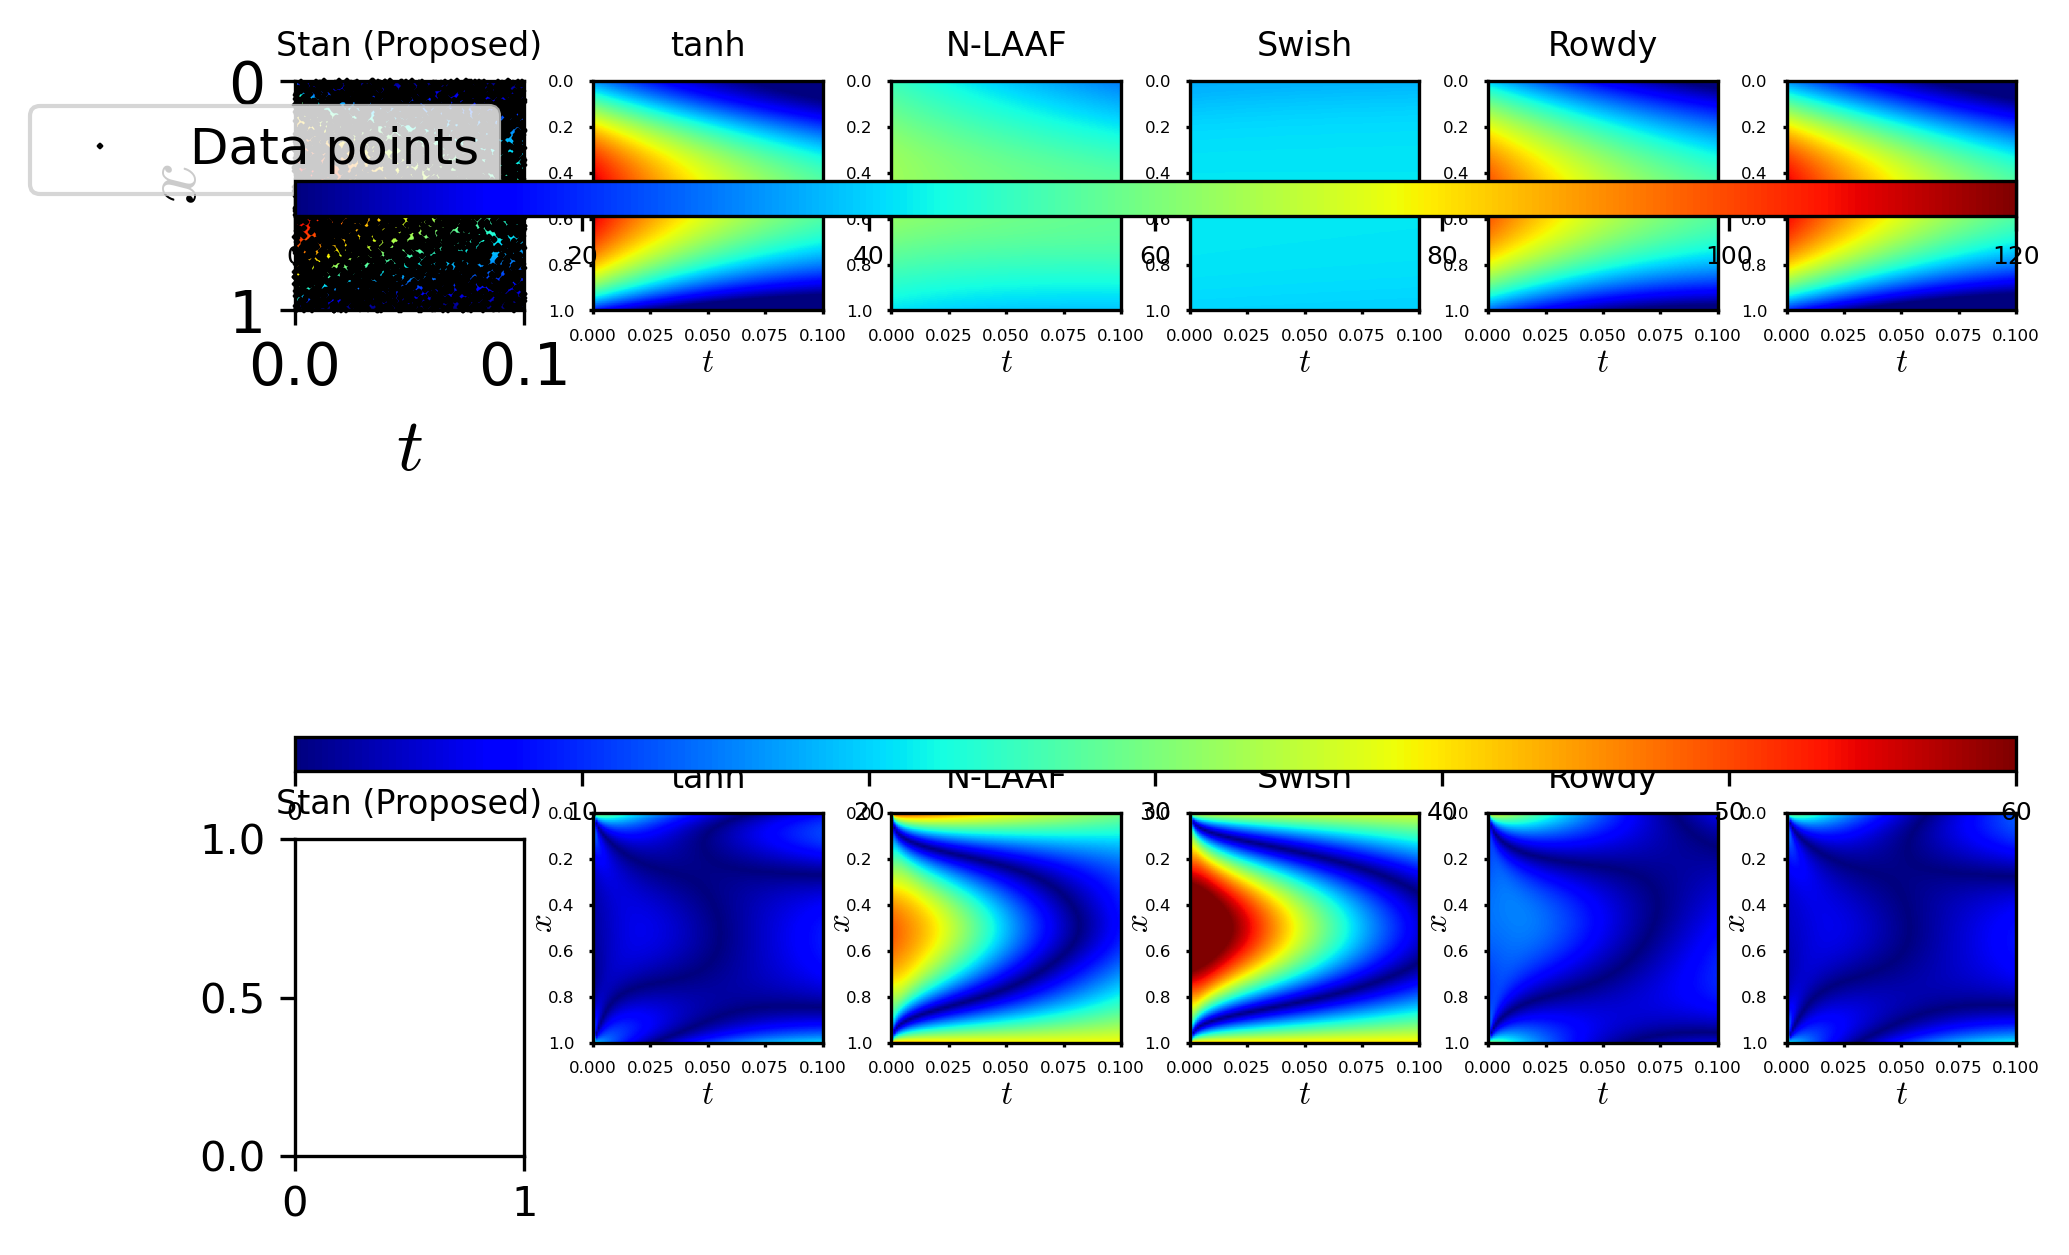

In [9]:
fig, ax_full = plt.subplots(2,6)

fig.dpi=300
fig.tight_layout()
cmap = plt.cm.jet
fig.subplots_adjust(left=None, bottom=0.3, right=None, top=1, wspace=0.4, hspace= None)

ax = ax_full[0,0]

img = ax.imshow(u_true.reshape(100,100),vmin = 0,vmax = 120,cmap = cmap,extent=[0,0.1,1,0],aspect = 0.1)

ax.set_xlabel('$t$', fontsize=18, math_fontfamily='cm')
ax.set_ylabel(' $x$',fontsize=18, math_fontfamily='cm')

ax.margins(x = 100,y = 100)
N_train = 5000
np.random.seed(1234)
x_train = np.random.uniform(x_ll,x_ul,(N_train,1))
t_train = np.random.uniform(0,0.1,(N_train,1))
ax.plot(t_train,x_train,'kx',markersize = 1, label = 'Data points',clip_on = False)

#ax.margins(x = 100,y = 100)
#np.random.RandomState(1234)
#idx_plt = np.random.randint(0,np.shape(xt_bound)[0],200)
# ax.plot(xt_bound[idx_plt,1],xt_bound[idx_plt,0],'kx',markersize = 6, label = 'Data (200 points)',clip_on = False)

ax.legend(loc = 'upper right',framealpha = 0.8,fontsize = 'large')
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title('$\\baru(x,t)$',fontsize=18, math_fontfamily='cm')





ax = ax_full[0,:]

for i in range(1,6):
    img = ax[i].imshow(u_pred[:,i-1].reshape(100,100),vmin = 0,vmax = 120,cmap = cmap,extent=[0,0.1,1,0],aspect = 0.1)
    
    ax[i].set_xlabel('$t$', fontsize=8, math_fontfamily='cm', labelpad=0.5)
    ax[i].set_ylabel(' $x$',fontsize=8, math_fontfamily='cm', labelpad=0.5)
    
    ax[i].tick_params(axis='x', labelsize=4,length = 1)
    ax[i].tick_params(axis='y', labelsize=4,length = 1)
    
    ax[i].yaxis.set_label_coords(-0.15,0.5)
    

cbar = fig.colorbar(img, ax=ax,location = 'top',orientation = 'horizontal', aspect = 50, panchor = (0,1.3),pad = 0.15)
cbar.ax.tick_params(labelsize=6,labelbottom = True,labeltop = False, bottom =True, top = False) 


ax[0].set_title('Stan (Proposed)',fontsize=8, math_fontfamily='cm')
ax[1].set_title('tanh',fontsize=8, math_fontfamily='cm')
ax[2].set_title('N-LAAF',fontsize=8, math_fontfamily='cm')
ax[3].set_title('Swish',fontsize=8, math_fontfamily='cm')
ax[4].set_title('Rowdy',fontsize=8, math_fontfamily='cm')

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)


ax = ax_full[1,:]
for i in range(1,6):
    img = ax[i].imshow(np.abs(u_pred[:,i-1].reshape(-1,1) - u_true).reshape(100,100),vmin =0,vmax =60,cmap = cmap,extent=[0,0.1,1,0],aspect = 0.1)

    ax[i].set_xlabel('$t$', fontsize=8, math_fontfamily='cm', labelpad=0.5)
    ax[i].set_ylabel(' $x$',fontsize=8, math_fontfamily='cm', labelpad=0.5)
    
    
    ax[i].tick_params(axis='x', labelsize=4,length = 1)
    ax[i].tick_params(axis='y', labelsize=4,length = 1)
    
    ax[i].yaxis.set_label_coords(-0.15,0.5)

cbar = fig.colorbar(img, ax=ax,location = 'top',orientation = 'horizontal', aspect = 50, panchor = (0,1.3),pad = 0.15)
cbar.ax.tick_params(labelsize=6,labelbottom = True,labeltop = False, bottom =True, top = False) 

#ax.set_xticks([0,10]) 
ax[0].set_title('Stan (Proposed)',fontsize=8, math_fontfamily='cm')
ax[1].set_title('tanh',fontsize=8, math_fontfamily='cm')
ax[2].set_title('N-LAAF',fontsize=8, math_fontfamily='cm')
ax[3].set_title('Swish',fontsize=8, math_fontfamily='cm')
ax[4].set_title('Rowdy',fontsize=8, math_fontfamily='cm')




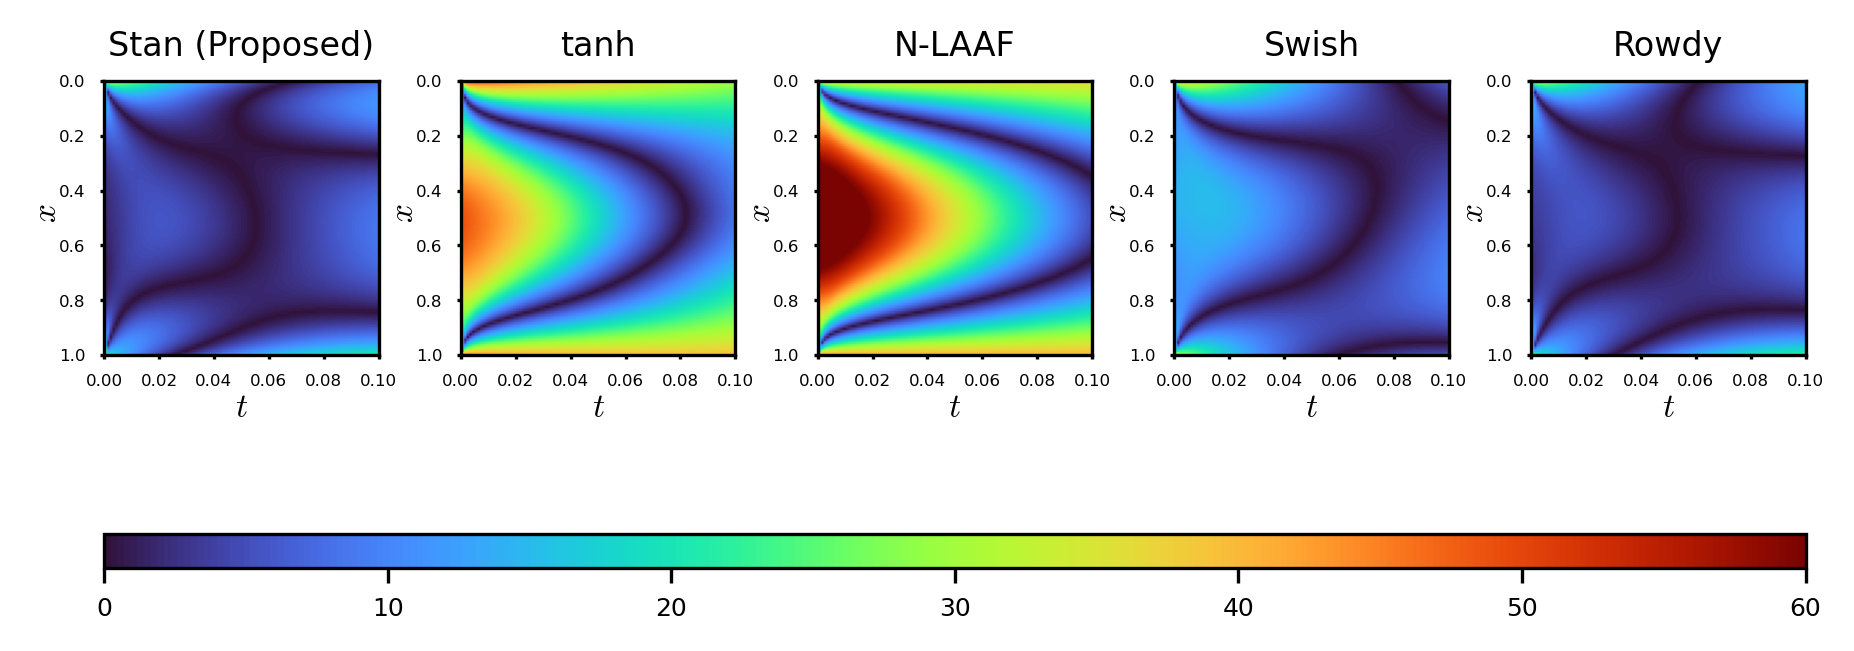

In [10]:
fig, ax = plt.subplots(1,5)

fig.dpi=300
fig.tight_layout()
cmap = plt.cm.turbo

for i in range(5):
    img = ax[i].imshow(np.abs(u_pred[:,i].reshape(-1,1) - u_true).reshape(100,100),vmin =0,vmax =60,cmap = cmap,extent=[0,0.1,1,0],aspect = 0.1)

    ax[i].set_xlabel('$t$', fontsize=8, math_fontfamily='cm', labelpad=0.5)
    ax[i].set_ylabel(' $x$',fontsize=8, math_fontfamily='cm', labelpad=0.5)
    
    
    ax[i].tick_params(axis='x', labelsize=4,length = 1)
    ax[i].tick_params(axis='y', labelsize=4,length = 1)
    
    ax[i].yaxis.set_label_coords(-0.15,0.5)

cbar = fig.colorbar(img, ax=ax,location = 'top',orientation = 'horizontal', aspect = 50, panchor = (0,1.3),pad = 0.15)
cbar.ax.tick_params(labelsize=6,labelbottom = True,labeltop = False, bottom =True, top = False) 

#ax.set_xticks([0,10]) 
ax[0].set_title('Stan (Proposed)',fontsize=8, math_fontfamily='cm')
ax[1].set_title('tanh',fontsize=8, math_fontfamily='cm')
ax[2].set_title('N-LAAF',fontsize=8, math_fontfamily='cm')
ax[3].set_title('Swish',fontsize=8, math_fontfamily='cm')
ax[4].set_title('Rowdy',fontsize=8, math_fontfamily='cm')


fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)


# plt.savefig(prob_name + 'error_comparison.eps', format='eps',pad_inches=0, bbox_inches='tight')

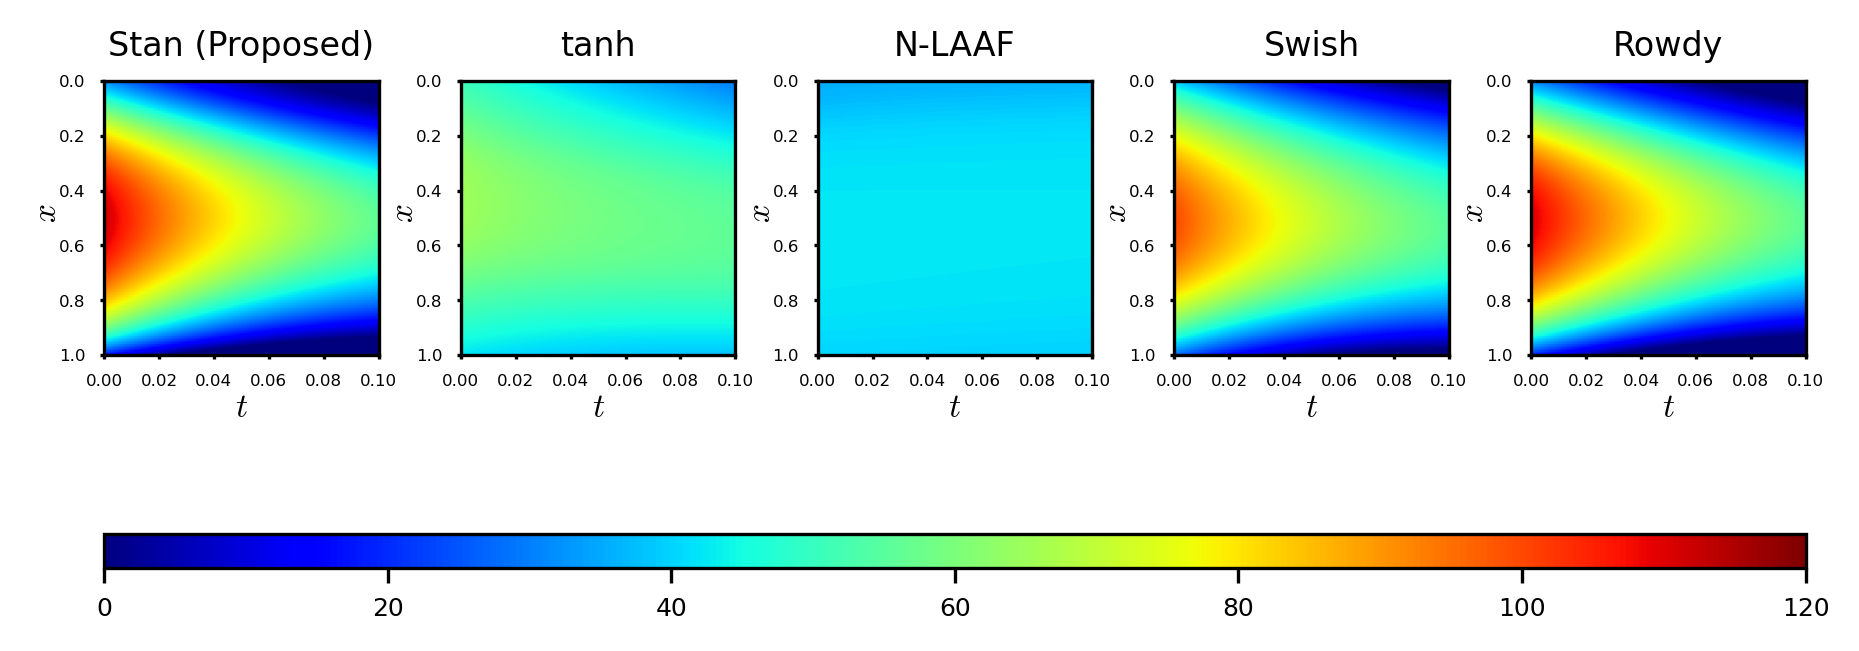

In [11]:
fig, ax = plt.subplots(1,5)

fig.dpi=300
fig.tight_layout()
cmap = plt.cm.jet

for i in range(5):
    img = ax[i].imshow(u_pred[:,i].reshape(100,100),vmin = 0,vmax = 120,cmap = cmap,extent=[0,0.1,1,0],aspect = 0.1)
    
    ax[i].set_xlabel('$t$', fontsize=8, math_fontfamily='cm', labelpad=0.5)
    ax[i].set_ylabel(' $x$',fontsize=8, math_fontfamily='cm', labelpad=0.5)
    
    ax[i].tick_params(axis='x', labelsize=4,length = 1)
    ax[i].tick_params(axis='y', labelsize=4,length = 1)
    
    ax[i].yaxis.set_label_coords(-0.15,0.5)
    

cbar = fig.colorbar(img, ax=ax,location = 'top',orientation = 'horizontal', aspect = 50, panchor = (0,1.3),pad = 0.15)
cbar.ax.tick_params(labelsize=6,labelbottom = True,labeltop = False, bottom =True, top = False) 


ax[0].set_title('Stan (Proposed)',fontsize=8, math_fontfamily='cm')
ax[1].set_title('tanh',fontsize=8, math_fontfamily='cm')
ax[2].set_title('N-LAAF',fontsize=8, math_fontfamily='cm')
ax[3].set_title('Swish',fontsize=8, math_fontfamily='cm')
ax[4].set_title('Rowdy',fontsize=8, math_fontfamily='cm')

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)


# plt.savefig(prob_name+'prediction_comparison.eps', format='eps',pad_inches=0, bbox_inches='tight')

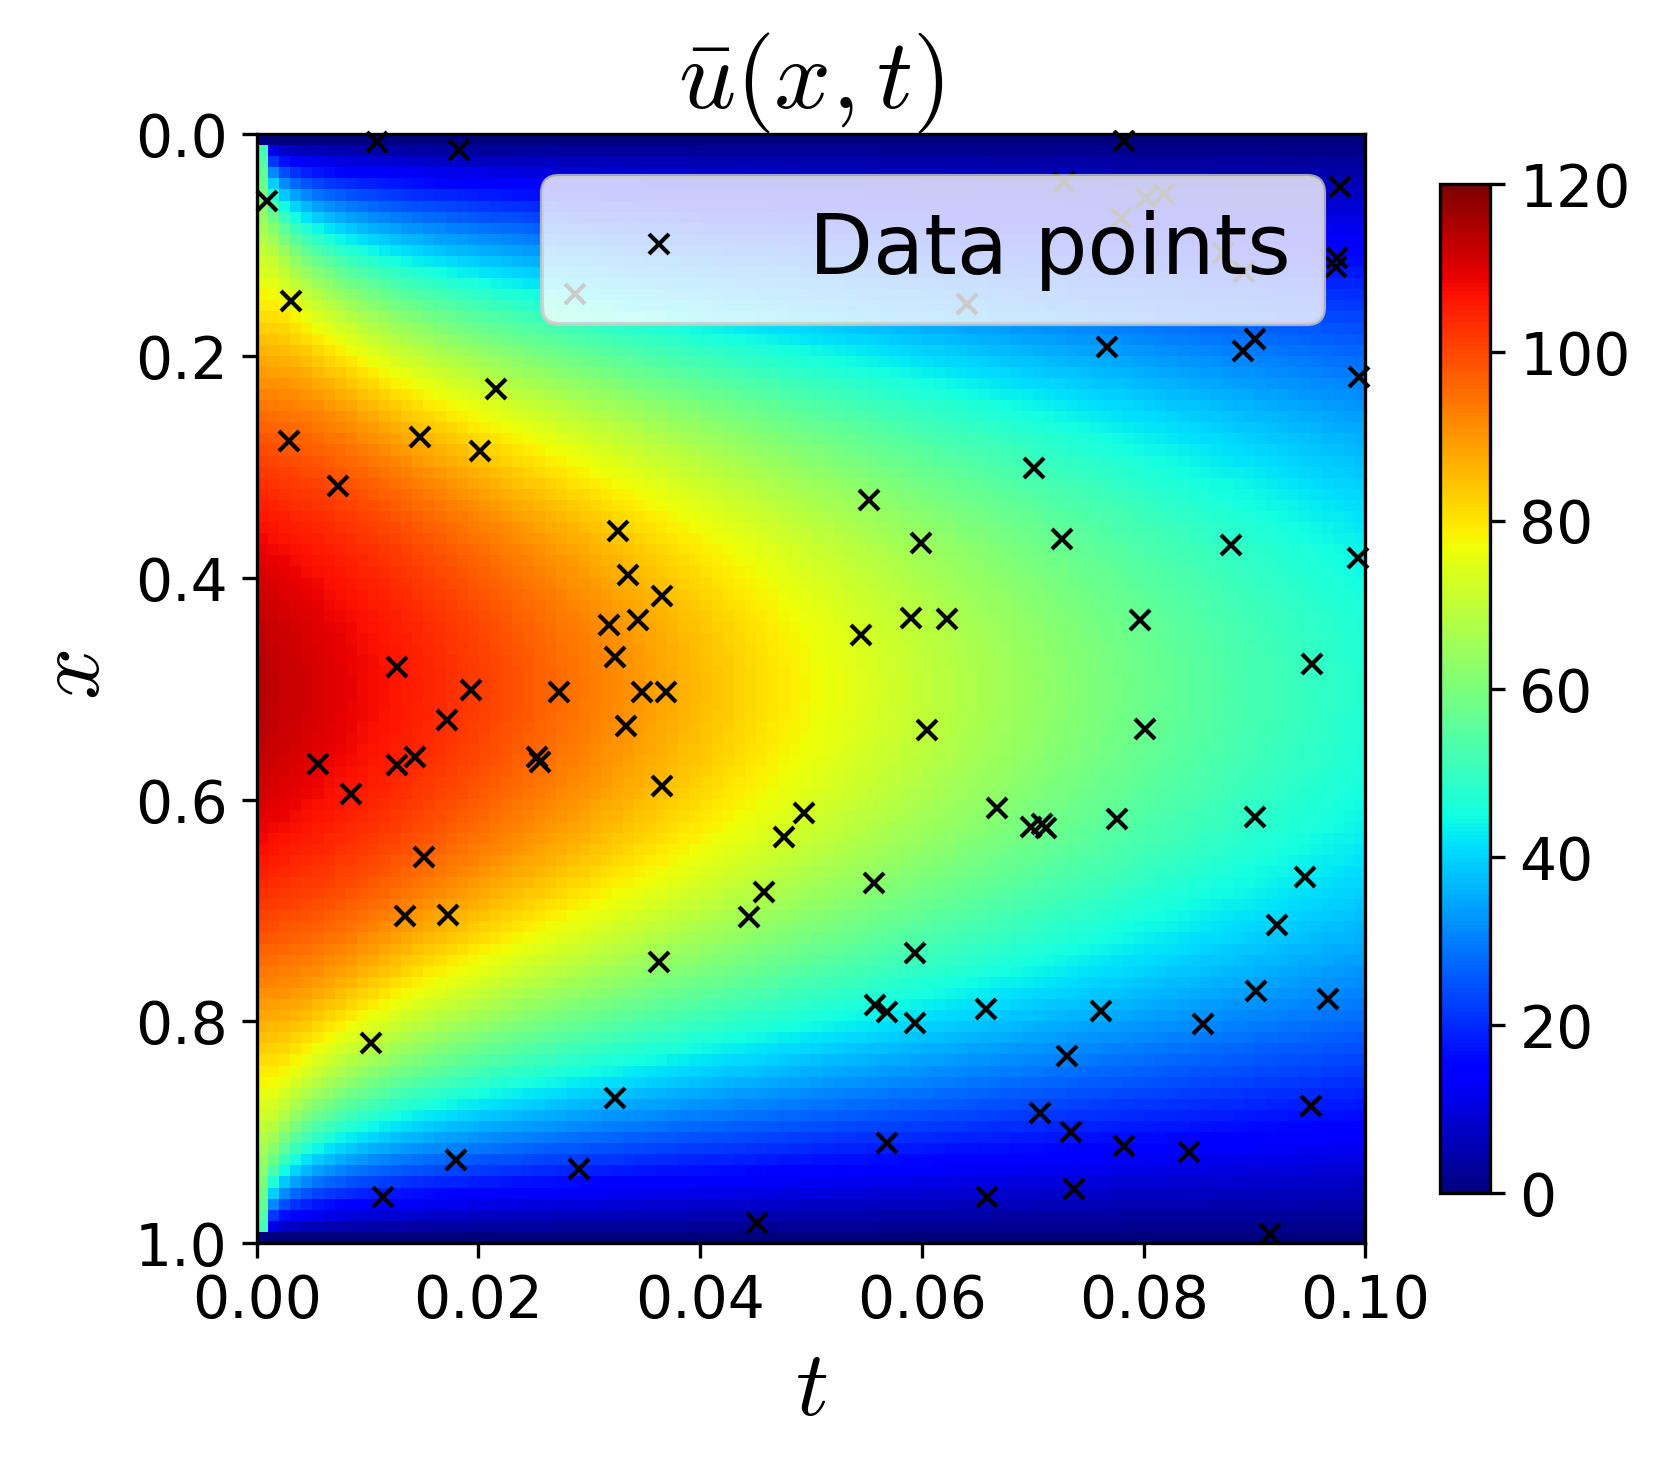

In [13]:
fig, ax = plt.subplots()
fig.dpi = 300

cmap = plt.cm.jet

img = ax.imshow(u_true.reshape(100,100),vmin = 0,vmax = 120,cmap = cmap,extent=[0,0.1,1,0],aspect = 0.1)

cbar = fig.colorbar(img, ax=ax,location = 'right',orientation = 'vertical', aspect = 20,pad = 0.05, extend = 'neither',shrink = 0.91)
cbar.ax.tick_params(labelsize=14,labelright = True, right = True) 

#ax.set_xticks([0,10]) 
ax.set_xlabel('$t$', fontsize=22, math_fontfamily='cm')
ax.set_ylabel(' $x$',fontsize=22, math_fontfamily='cm')

ax.margins(x = 100,y = 100)
N_train = 100
np.random.seed(1234)
x_train = np.random.uniform(x_ll,x_ul,(N_train,1))
t_train = np.random.uniform(0,0.1,(N_train,1))
ax.plot(t_train,x_train,'kx',markersize = 5, label = 'Data points',clip_on = False)

#ax.margins(x = 100,y = 100)
#np.random.RandomState(1234)
#idx_plt = np.random.randint(0,np.shape(xt_bound)[0],200)
# ax.plot(xt_bound[idx_plt,1],xt_bound[idx_plt,0],'kx',markersize = 6, label = 'Data (200 points)',clip_on = False)

ax.legend(loc = 'upper right',framealpha = 0.8,fontsize = 20)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title('$\\baru(x,t)$',fontsize=24, math_fontfamily='cm')

# plt.savefig(prob_name+'true.svg', format='svg',pad_inches=0, bbox_inches='tight',transparent = True)
plt.savefig(prob_name+'true_FSU.svg', format='svg',pad_inches=0, bbox_inches='tight',transparent = True)


In [ ]:
#Relative Error
print('Relative Error')
print(mean_test_loss_stan[-1])
print(mean_test_loss_tanh[-1])
print(mean_test_loss_atanh[-1])
print(mean_test_loss_swish[-1])
print(mean_test_loss_rowdy[-1])

In [ ]:
test_loss_stan =  data_stan['test_mse_loss']
test_loss_tanh =  data_tanh['test_mse_loss']
test_loss_atanh =  data_atanh['test_mse_loss']
test_loss_swish =  data_swish['test_mse_loss']
test_loss_rowdy =  data_rowdy['test_mse_loss']


mean_test_loss_stan = np.zeros((num_steps,1))
mean_test_loss_tanh = np.zeros((num_steps,1))
mean_test_loss_atanh = np.zeros((num_steps,1))
mean_test_loss_swish = np.zeros((num_steps,1))
mean_test_loss_rowdy = np.zeros((num_steps,1))


for i in range(10):
    mean_test_loss_stan = mean_test_loss_stan + test_loss_stan[i,:num_steps].reshape(-1,1)
    mean_test_loss_tanh = mean_test_loss_tanh + test_loss_tanh[i,:num_steps].reshape(-1,1)
    mean_test_loss_atanh = mean_test_loss_atanh + test_loss_atanh[i,:num_steps].reshape(-1,1)
    mean_test_loss_swish = mean_test_loss_swish + test_loss_swish[i,:num_steps].reshape(-1,1)
    mean_test_loss_rowdy = mean_test_loss_rowdy + test_loss_rowdy[i,:num_steps].reshape(-1,1)
    
        
mean_test_loss_stan = mean_test_loss_stan/10
mean_test_loss_tanh = mean_test_loss_tanh/10
mean_test_loss_atanh = mean_test_loss_atanh/10
mean_test_loss_swish = mean_test_loss_swish/10
mean_test_loss_rowdy = mean_test_loss_rowdy/10

print('MSE')
print(mean_test_loss_stan[-1])
print(mean_test_loss_tanh[-1])
print(mean_test_loss_atanh[-1])
print(mean_test_loss_swish[-1])
print(mean_test_loss_rowdy[-1])

In [ ]:
print('Total Time')
print(np.mean(data_stan['Time']))
print(np.mean(data_tanh['Time']))
print(np.mean(data_atanh['Time']))
print(np.mean(data_swish['Time']))
print(np.mean(data_rowdy['Time']))

In [ ]:
max_time = np.max(np.vstack((data_stan['Time'],data_tanh['Time'],data_atanh['Time'],data_swish['Time'],data_rowdy['Time'])))

ttime_stan = data_stan['Thresh Time']
ttime_tanh = data_tanh['Thresh Time']
ttime_atanh = data_atanh['Thresh Time']
ttime_swish = data_swish['Thresh Time']
ttime_rowdy = data_rowdy['Thresh Time']

ttime_stan[np.isnan(ttime_stan)] = max_time
ttime_tanh[np.isnan(ttime_tanh)] = max_time
ttime_atanh[np.isnan(ttime_atanh)] = max_time
ttime_swish[np.isnan(ttime_swish)] = max_time
ttime_rowdy[np.isnan(ttime_rowdy)] = max_time

print('Threshold Time')
print(np.mean(ttime_stan))
print(np.mean(ttime_tanh))
print(np.mean(ttime_atanh))
print(np.mean(ttime_swish))
print(np.mean(ttime_rowdy))

In [ ]:
tep_stan = data_stan['Thresh epoch']
tep_tanh = data_tanh['Thresh epoch']
tep_atanh = data_atanh['Thresh epoch']
tep_swish = data_swish['Thresh epoch']
tep_rowdy = data_rowdy['Thresh epoch']

print('Threshold Epoch')
print(np.mean(tep_stan))
print(np.mean(tep_tanh))
print(np.mean(tep_atanh))
print(np.mean(tep_swish))
print(np.mean(tep_rowdy))